In [1]:
%load_ext autoreload
%autoreload 2

In [52]:
from os import path as op

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from dac_analysis import get_df, to_results, value_counts
from dac_config import (
    agreement_cmap,
    categories,
    green,
    groups,
    lightgreen,
    orange,
    red,
    scale,
    yellow,
    yellowgreen,
)

sns.set()


def plot(results, category_names, colors=None, limit=5.0, height=0.8, figsize=(25,5),fname=None):
    """
    Parameters
    ----------
    results : dict
        A mapping from question labels to a list of answers per category.
        It is assumed all lists contain the same number of entries and that
        it matches the length of *category_names*.
    category_names : list of str
        The category labels.
    """
    labels = list(results.keys())
    data = np.array(list(results.values()))
    data_cum = data.cumsum(axis=1)
    if colors is None:
        category_colors = plt.get_cmap("RdYlGn")(np.linspace(0.15, 0.85, data.shape[1]))
    else:
        category_colors = colors

    fig, ax = plt.subplots(figsize=figsize)
    # fig.suptitle("How much do you trust in these groups to act in the interest of society?", fontsize=16)
    ax.invert_yaxis()
    ax.xaxis.set_visible(False)
    ax.set_xlim(0, np.sum(data, axis=1).max())

    for i, (colname, color) in enumerate(zip(category_names, category_colors)):
        widths = data[:, i]
        starts = data_cum[:, i] - widths
        ax.barh(
            labels,
            widths,
            left=starts,
            height=height,
            label=colname,
            color=color,
            # edgecolor="black",
        )
        ax.legend(loc="best", fontsize=24)
        # ax.set_xlabel(colname, fontsize = 20)
        xcenters = starts + widths / 2

        # r, g, b, _ = color
        text_color = "black"  # "white" if r * g * b < 0.5 else "darkgrey"
        for y, (x, c) in enumerate(zip(xcenters, widths)):
            if c > limit:
                ax.text(
                    x,
                    y,
                    "{:3.2f} %".format(c),
                    ha="center",
                    va="center",
                    color=text_color,
                    size=16,
                )

    ax.legend(
        ncol=len(category_names),
        bbox_to_anchor=(0, 1),
        loc="lower left",
        fontsize=18,  # "large",
    )

    ax.set_yticks(np.arange(len(labels)), labels=labels, size=16)

    if fname:
        fig.savefig(op.join("figs", fname), transparent=True, bbox_inches="tight")
    return fig, ax

In [53]:
df = get_df("data.csv", drop=False, translate=True)

shorts = {
    "DAC Awareness": "Haben Sie schon von Technologien zur Entnahme von Kohlendioxid (CO2) aus der Luft (auf Englisch Direct Air Capture (DAC)) gehört?",
    "DAC Knowledge": "Wie gut sind ihre Kenntnisse dieser Technologien?",
    "Storage Awareness": "Haben Sie schon von Kohlendioxid (CO2)-Speicherung gehört?",
    "Storage Knowledge": "Wie gut sind ihre Kenntnisse der CO2-Speicherungstechnologien?",
    "Initial Storage Support": "CO2-Speicherung",
    "Final Storage Support": "CO2-Speicherung.1",
    "Initial DAC Support": "Direct Air Capture (DAC)",
    "Final DAC Support": "Direct Air Capture (DAC).1",
}

DAC_KNOWLEDGE_DE = "Wie gut sind ihre Kenntnisse dieser Technologien?"
STORAGE_KNOWLEDGE_DE = "Wie gut sind ihre Kenntnisse der CO2-Speicherungstechnologien?"
DAC_KNOWLEDGE_EN = "How would you rate your knowledge of DAC?"
STORAGE_KNOWLEDGE_EN = "How would you rate your knowledge of CO2 Storage?"

labels = {
    DAC_KNOWLEDGE_DE: "Wie gut sind ihre Kenntnisse von Technologien\n zur Entnahme von Kohlendioxid (CO2) aus der Luft?",
    STORAGE_KNOWLEDGE_DE: "Wie gut sind ihre Kenntnisse\n der CO2-Speicherungstechnologien?",
    DAC_KNOWLEDGE_EN: "How would you rate your\n knowledge of DAC?",
    STORAGE_KNOWLEDGE_EN: "How would you rate your\n knowledge of CO2 Storage?",
}

DAC_KNOWLEDGE = DAC_KNOWLEDGE_EN
STORAGE_KNOWLEDGE = STORAGE_KNOWLEDGE_EN


# df = df[[DAC_KNOWLEDGE, STORAGE_KNOWLEDGE]]
df.loc[df[DAC_KNOWLEDGE].isnull(), DAC_KNOWLEDGE] = "Never heard"
df.loc[df[STORAGE_KNOWLEDGE].isnull(), STORAGE_KNOWLEDGE] = "Never heard"

knowledge = df[[DAC_KNOWLEDGE, STORAGE_KNOWLEDGE]]


category_names = categories["knowledge_en"]
counts = value_counts(knowledge)
results = to_results(counts, category_names, labels)

(<Figure size 2500x500 with 1 Axes>, <Axes: >)

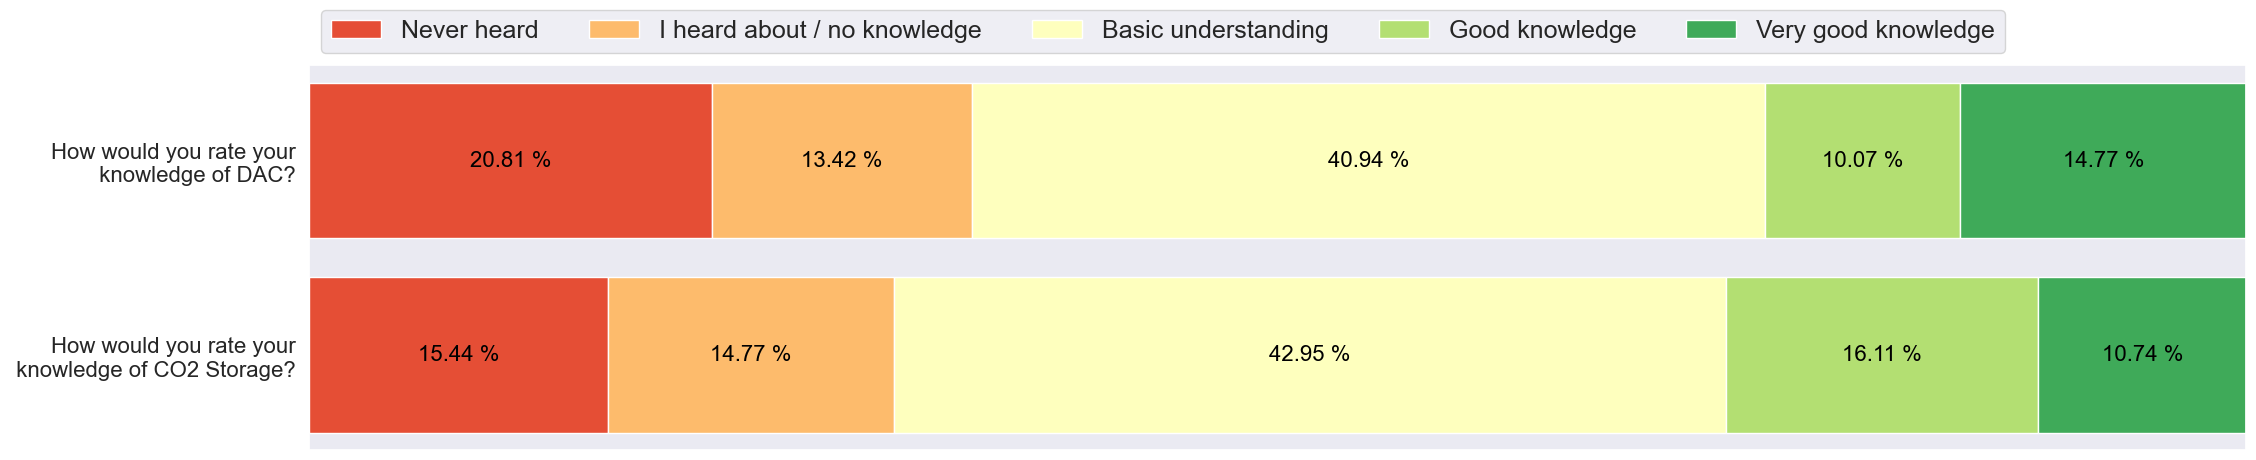

In [54]:
plot(results, category_names, fname="knowledge.png")

(<Figure size 2500x500 with 1 Axes>, <Axes: >)

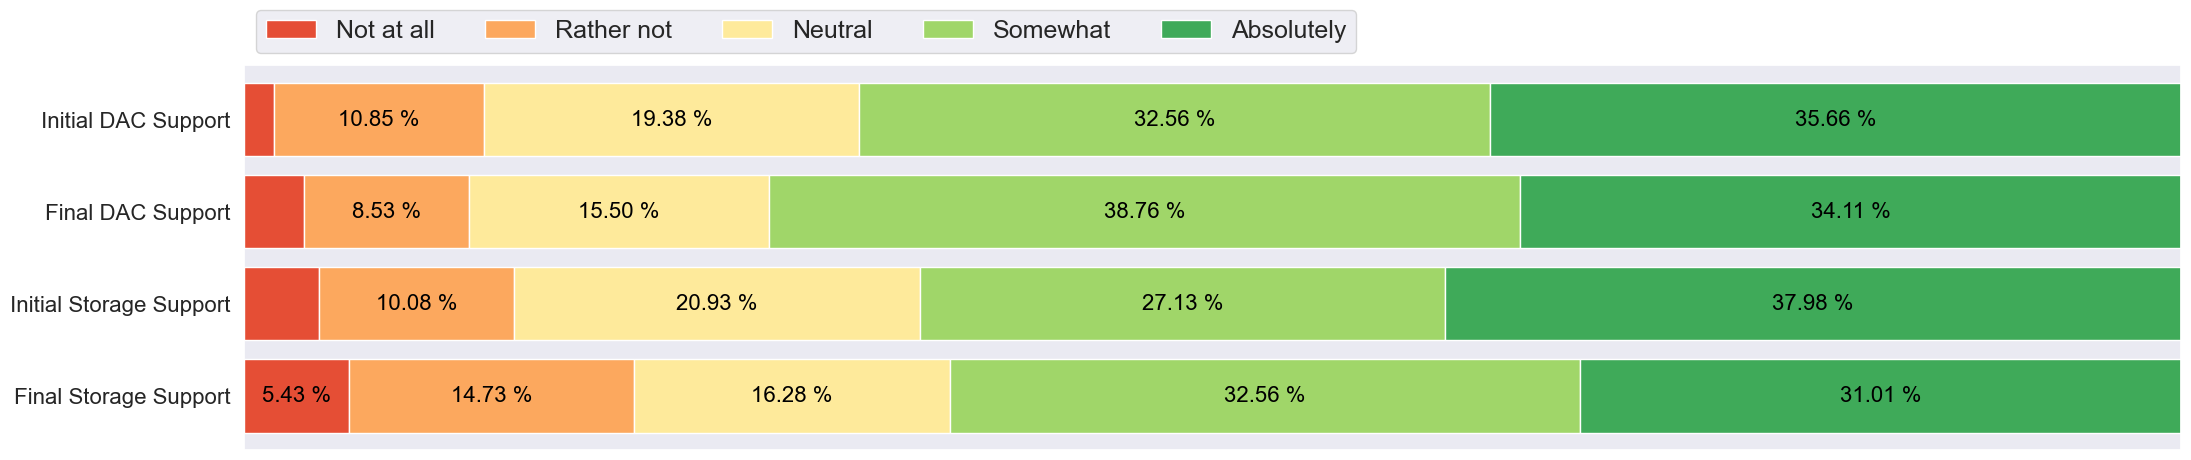

In [55]:
acceptance = [
    "Initial DAC Support",
    "Final DAC Support",
    "Initial Storage Support",
    "Final Storage Support",
]

acceptance = df[acceptance].dropna()

category_names = categories["support_en"]
counts = value_counts(acceptance)
results = to_results(counts, category_names, labels)

colors = ["red", "orange", "lightyellow", "greenyellow", "limegreen"]
colors = [red, orange, yellow, lightgreen, green]

plot(results, category_names, colors=colors, fname="support.png")
# plt.show()

(<Figure size 2500x500 with 1 Axes>, <Axes: >)

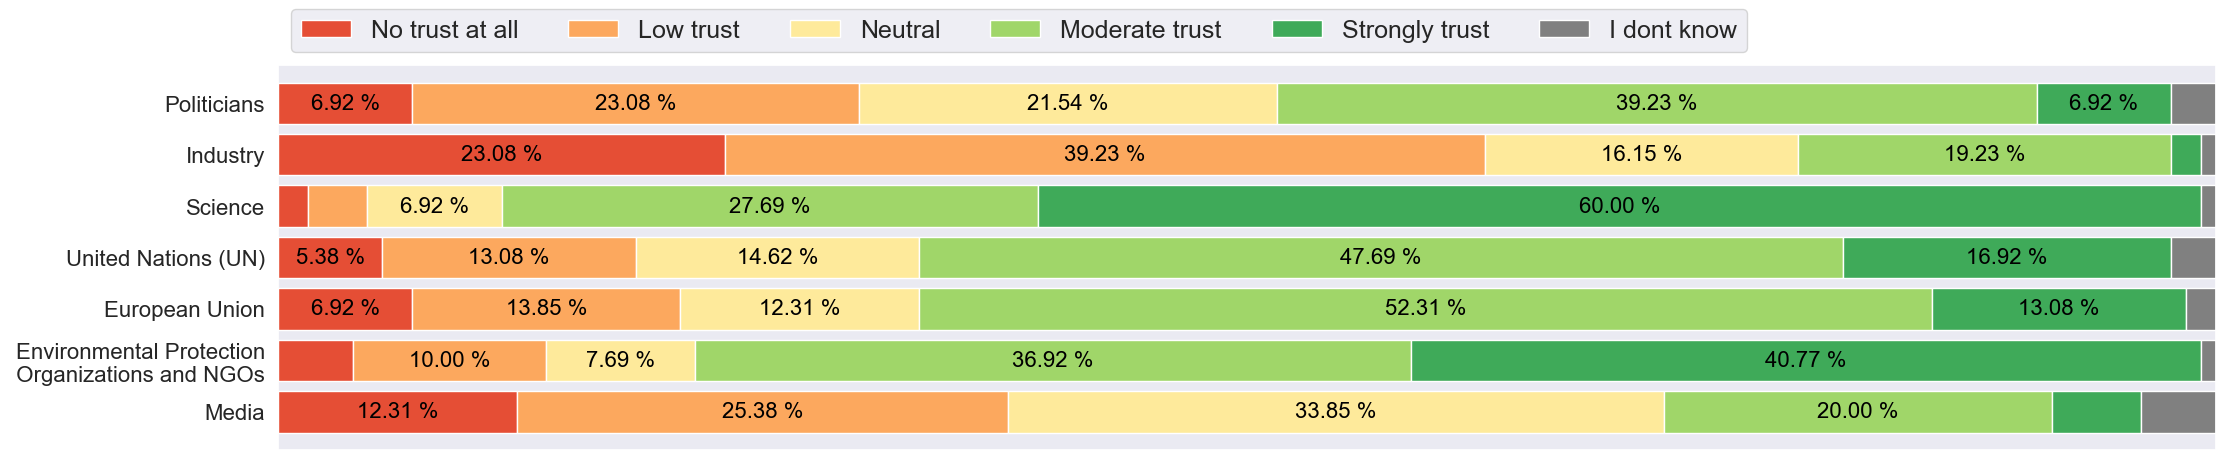

In [56]:
trust = [
    "Politicians",
    "Industry",
    "Science",
    "United Nations (UN)",
    "European Union",
    "Environmental Protection Organizations and NGOs",
    "Media",
]
trust = df[trust].dropna()

category_names = categories["trust_en"]
counts = value_counts(trust)
results = to_results(
    counts,
    category_names,
    labels={
        "Environmental Protection Organizations and NGOs": "Environmental Protection\n Organizations and NGOs"
    },
)

colors = ["red", "orange", "lightyellow", "greenyellow", "limegreen", "gray"]
colors = agreement_cmap
plot(results, category_names, colors=colors, fname="trust.png")
# plt.show()

(<Figure size 2500x500 with 1 Axes>, <Axes: >)

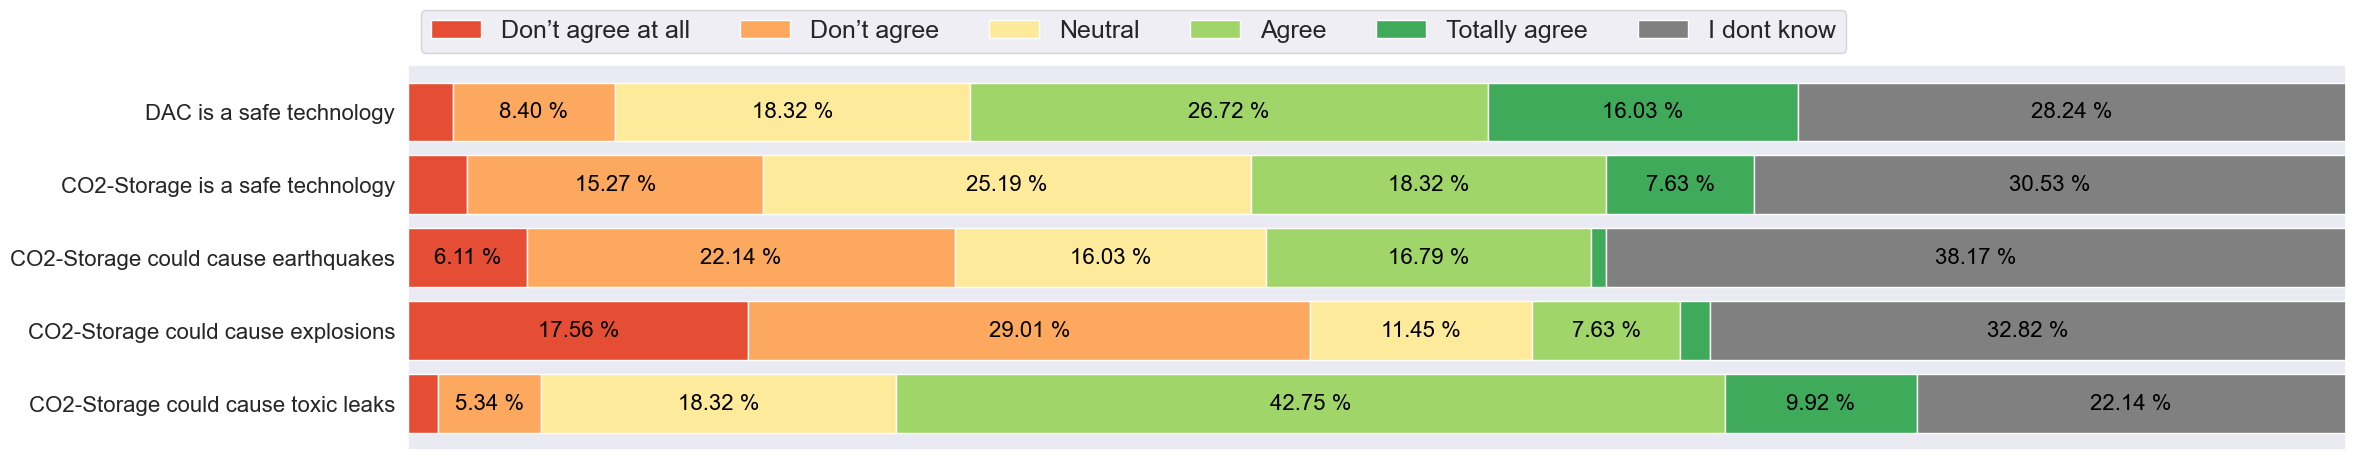

In [57]:
risk = [
    "DAC is a safe technology",
    "CO2-Storage is a safe technology",
    "CO2-Storage could cause earthquakes",
    "CO2-Storage could cause explosions",
    "CO2-Storage could cause toxic leaks",
]
risk = df[risk].dropna()

category_names = categories["agreement_en"]
counts = value_counts(risk)

results = to_results(counts, category_names)
plot(results, category_names, colors=agreement_cmap, fname="risk.png")

In [14]:
social = ["Gender", "Age"]

social = df[social].dropna()
counts = value_counts(social)
# results = to_results(counts, category_names)
# plot(results, category_names, colors=agreement_cmap, fname="risk.png")

In [21]:
value_counts(social[social.Gender == "Male"])

{'Gender': {'Male': 1.0},
 'Age': {'30 - 39': 0.3068181818181818,
  '20 - 29': 0.26136363636363635,
  '40 - 49': 0.20454545454545456,
  '50 - 59': 0.14772727272727273,
  '60+': 0.07954545454545454}}

(<Figure size 2500x1500 with 1 Axes>, <Axes: >)

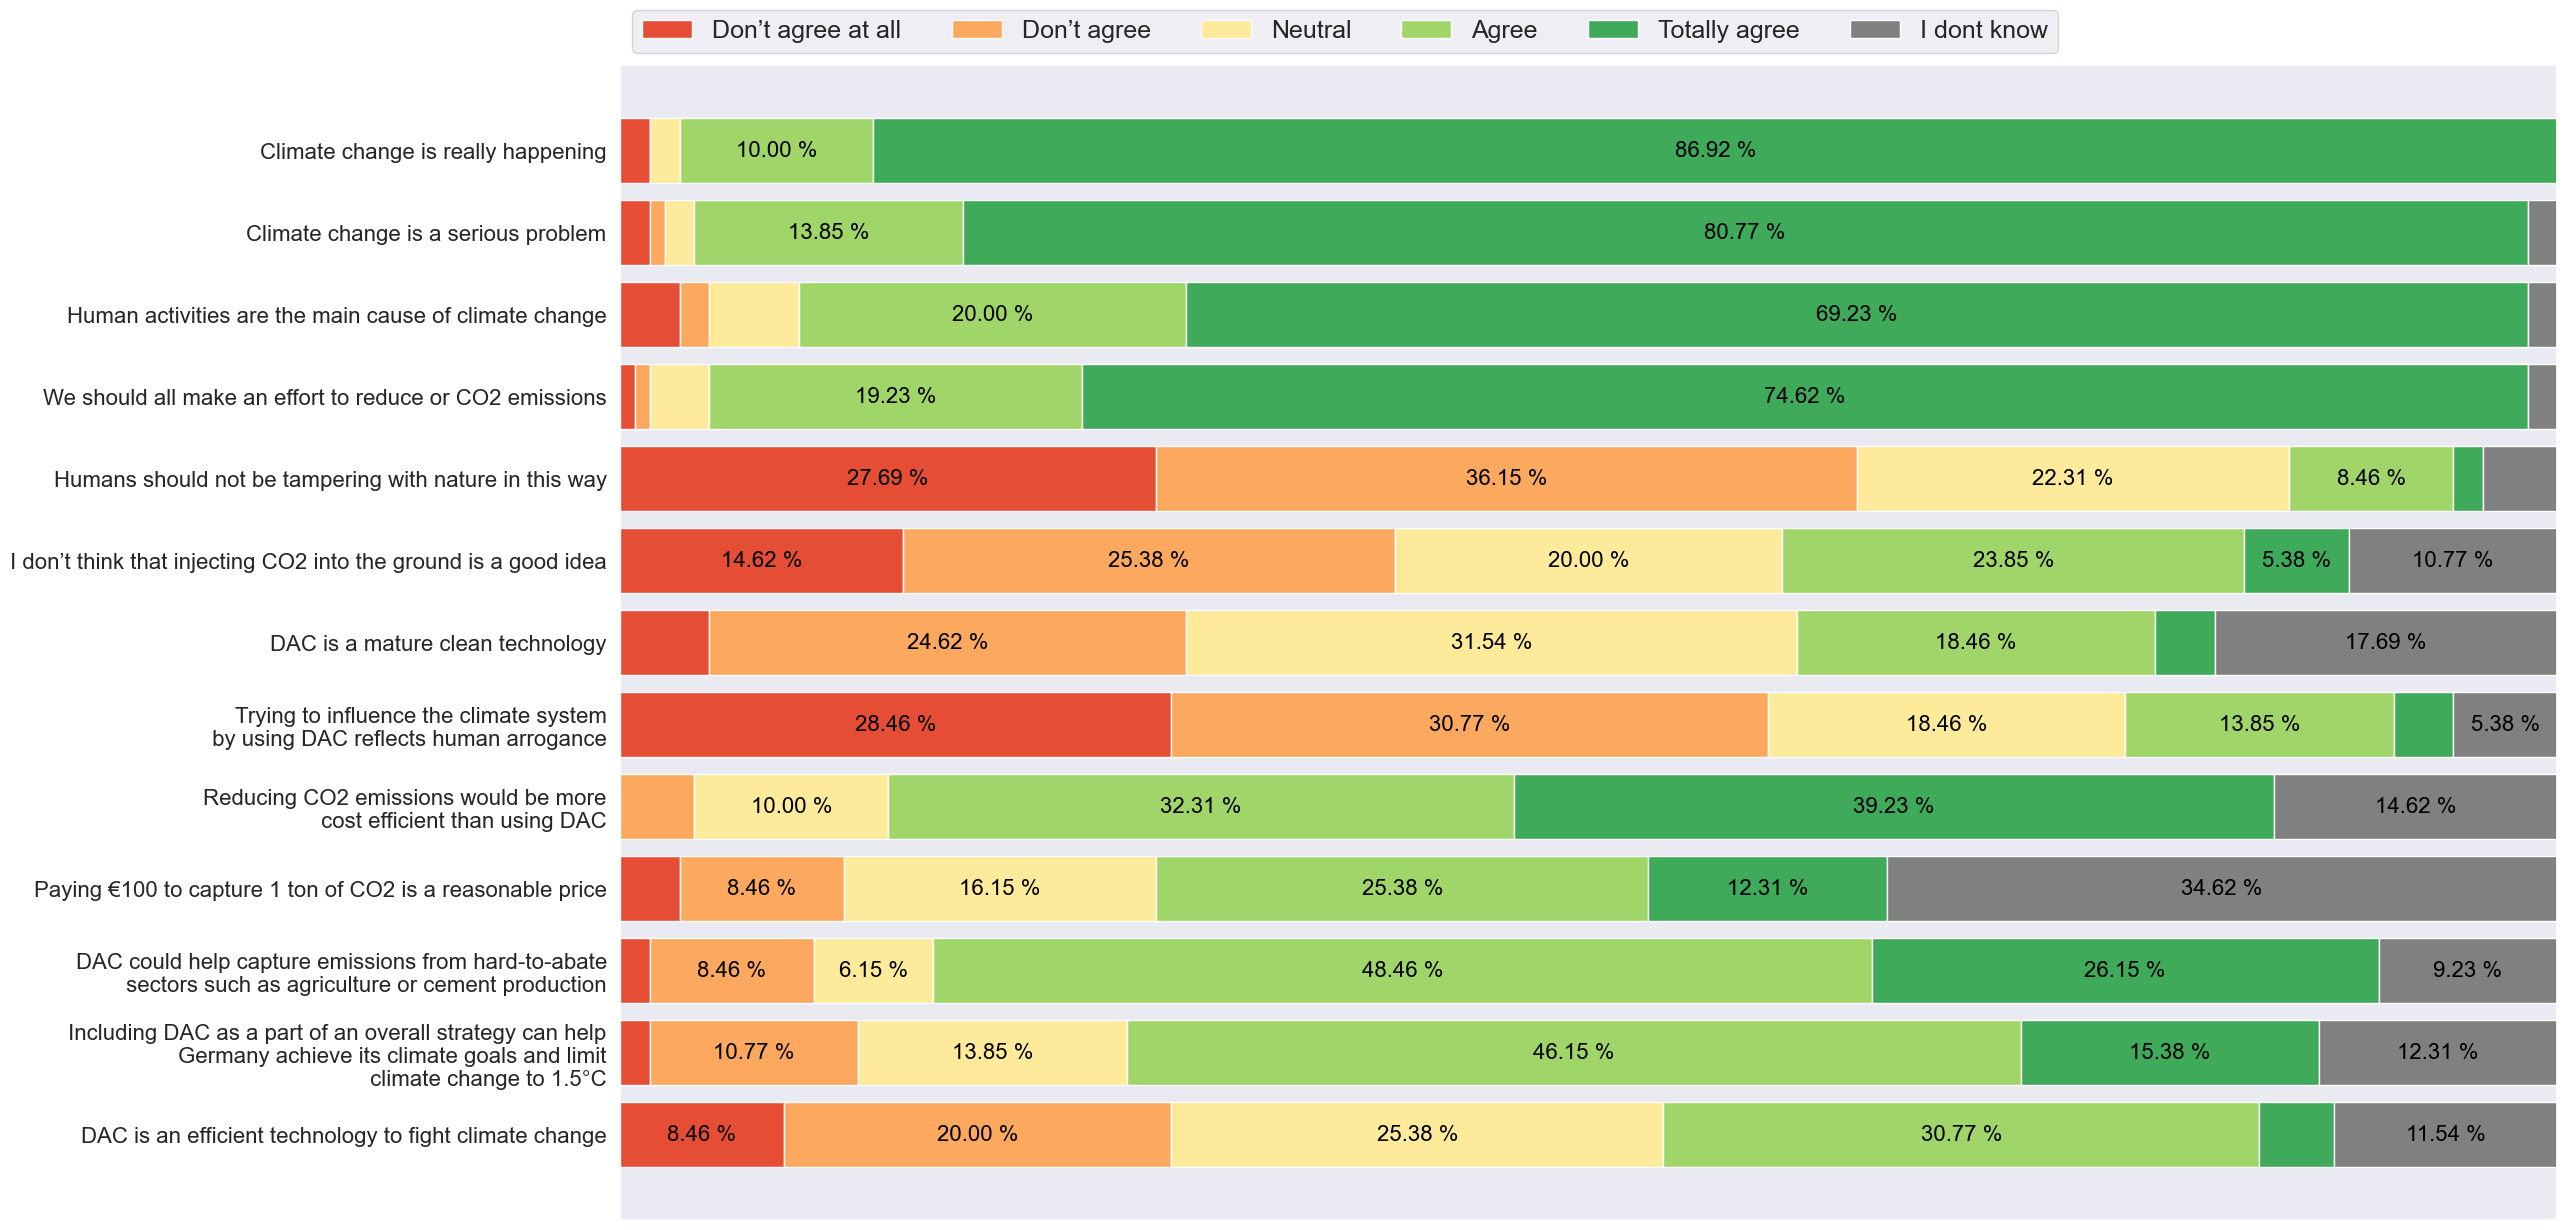

In [63]:
bonus = [
    "Climate change is really happening",
    "Climate change is a serious problem",
    "Human activities are the main cause of climate change",
    "We should all make an effort to reduce or CO2 emissions",
    "Humans should not be tampering with nature in this way",
    "I don’t think that injecting CO2 into the ground is a good idea",
    "DAC is a mature clean technology",
    "Trying to influence the climate system by using DAC reflects human arrogance",
    "Reducing CO2 emissions would be more cost efficient than using DAC",
    "Paying €100 to capture 1 ton of CO2 is a reasonable price",
    "DAC could help capture emissions from hard-to-abate sectors such as agriculture or cement production",
    "Including DAC as a part of an overall strategy can help Germany achieve its climate goals and limit climate change to 1.5°C",
    "DAC is an efficient technology to fight climate change",
]

category_names = categories["agreement_en"]
labels = {
    "Reducing CO2 emissions would be more cost efficient than using DAC": "Reducing CO2 emissions would be more\n cost efficient than using DAC",
    "DAC could help capture emissions from hard-to-abate sectors such as agriculture or cement production":"DAC could help capture emissions from hard-to-abate\n sectors such as agriculture or cement production",
    "Trying to influence the climate system by using DAC reflects human arrogance": "Trying to influence the climate system\n by using DAC reflects human arrogance",
    "Including DAC as a part of an overall strategy can help Germany achieve its climate goals and limit climate change to 1.5°C": "Including DAC as a part of an overall strategy can help\n Germany achieve its climate goals and limit\n climate change to 1.5°C",
}
counts = value_counts(df[bonus].dropna())
results = to_results(counts, category_names, labels=labels)
plot(results, category_names, colors=agreement_cmap, fname="bonus.png", height=0.8, figsize=(25,15))

In [43]:
counts

{'Climate change is really happening': {'Totally agree': 0.8692307692307693,
  'Agree': 0.1,
  'Don’t agree at all': 0.015384615384615385,
  'Neutral': 0.015384615384615385},
 'Climate change is a serious problem': {'Totally agree': 0.8076923076923077,
  'Agree': 0.13846153846153847,
  'Neutral': 0.015384615384615385,
  'Don’t agree at all': 0.015384615384615385,
  'I dont know': 0.015384615384615385,
  'Don’t agree': 0.007692307692307693},
 'Human activities are the main cause of climate change': {'Totally agree': 0.6923076923076923,
  'Agree': 0.2,
  'Neutral': 0.046153846153846156,
  'Don’t agree at all': 0.03076923076923077,
  'I dont know': 0.015384615384615385,
  'Don’t agree': 0.015384615384615385},
 'We should all make an effort to reduce or CO2 emissions': {'Totally agree': 0.7461538461538462,
  'Agree': 0.19230769230769232,
  'Neutral': 0.03076923076923077,
  'I dont know': 0.015384615384615385,
  'Don’t agree at all': 0.007692307692307693,
  'Don’t agree': 0.0076923076923076

In [40]:
results

{'Climate change is really happening': 0.0,
 'Climate change is a serious problem': 1.5384615384615385,
 'Human activities are the main cause of climate change': 1.5384615384615385,
 'We should all make an effort to reduce or CO2 emissions': 1.5384615384615385,
 'Humans should not be tampering with nature in this way': 3.8461538461538463,
 'I don’t think that injecting CO2 into the ground is a good idea': 10.76923076923077,
 'DAC is a mature clean technology': 17.692307692307693,
 'Trying to influence the climate system by using DAC reflects human arrogance': 5.384615384615385,
 'Reducing CO2 emissions would be more cost efficient than using DAC': 14.615384615384617,
 'Paying €100 to capture 1 ton of CO2 is a reasonable price': 34.61538461538461,
 'DAC could help capture emissions from hard-to-abate sectors such as agriculture or cement production': 9.230769230769232,
 'Including DAC as a part of an overall strategy can help Germany achieve its climate goals and limit climate change to

In [47]:
import math

import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle


def plot_colortable(colors, *, ncols=4, sort_colors=True):

    cell_width = 212
    cell_height = 22
    swatch_width = 48
    margin = 12

    # Sort colors by hue, saturation, value and name.
    if sort_colors is True:
        names = sorted(
            colors, key=lambda c: tuple(mcolors.rgb_to_hsv(mcolors.to_rgb(c)))
        )
    else:
        names = list(colors)

    n = len(names)
    nrows = math.ceil(n / ncols)

    width = cell_width * ncols + 2 * margin
    height = cell_height * nrows + 2 * margin
    dpi = 72

    fig, ax = plt.subplots(figsize=(width / dpi, height / dpi), dpi=dpi)
    fig.subplots_adjust(
        margin / width,
        margin / height,
        (width - margin) / width,
        (height - margin) / height,
    )
    ax.set_xlim(0, cell_width * ncols)
    ax.set_ylim(cell_height * (nrows - 0.5), -cell_height / 2.0)
    ax.yaxis.set_visible(False)
    ax.xaxis.set_visible(False)
    ax.set_axis_off()

    for i, name in enumerate(names):
        row = i % nrows
        col = i // nrows
        y = row * cell_height

        swatch_start_x = cell_width * col
        text_pos_x = cell_width * col + swatch_width + 7

        ax.text(
            text_pos_x,
            y,
            name,
            fontsize=14,
            horizontalalignment="left",
            verticalalignment="center",
        )

        ax.add_patch(
            Rectangle(
                xy=(swatch_start_x, y - 9),
                width=swatch_width,
                height=18,
                facecolor=colors[name],
                edgecolor="0.7",
            )
        )

    return fig

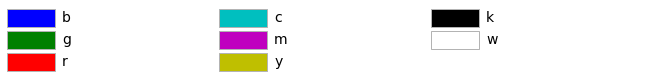

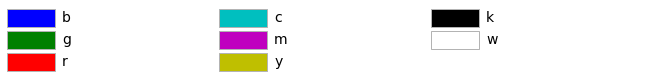

In [43]:
plot_colortable(mcolors.BASE_COLORS, ncols=3, sort_colors=False)

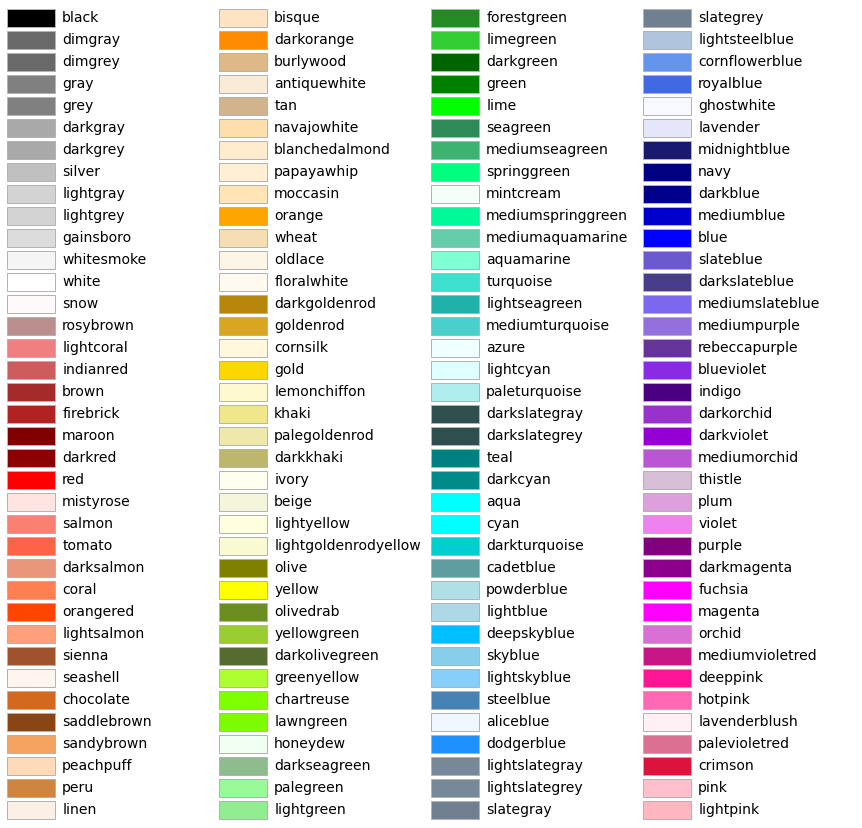

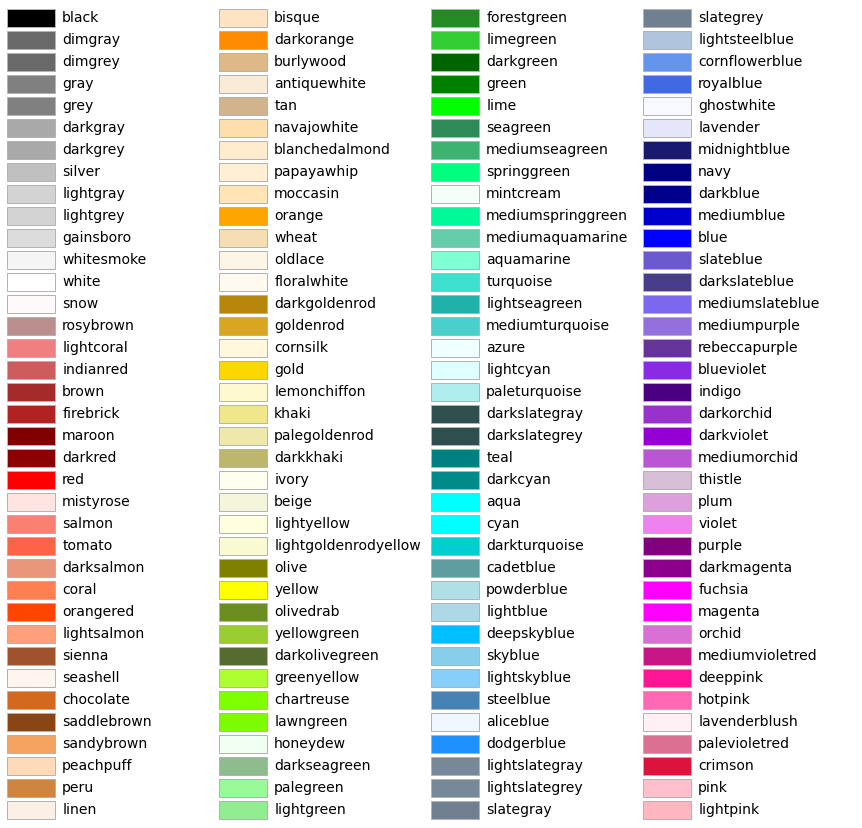

In [44]:
plot_colortable(mcolors.CSS4_COLORS)